# CAUSAL INFORMED PREDICTIVE MONITORING
---
## Dataset: Traffic

### imports

In [6]:
import pandas as pd
import missingno as msno
import causality
import elp
import os
import json

### load the data


In [7]:
log = pd.read_csv("../data/traffic_fines_1.csv", sep=";", encoding="iso-8859-1")

/tmp/ipykernel_104630/3521613392.py:1: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("../data/traffic_fines_1.csv", sep=";", encoding="iso-8859-1")


In [8]:
log.head()

,article,vehicleClass,amount,points,Case ID,Activity,Resource,lastSent,notificationType,dismissal,...,Complete Timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,...,2006-08-02 01:00:00,60,8,2,1,0.0,0.0,1,11246,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,...,2006-12-12 01:00:00,60,12,1,1,190080.0,190080.0,2,12380,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,...,2007-01-15 01:00:00,60,1,0,1,48960.0,239040.0,3,12202,deviant
3,157.0,A,71.5,0.0,A100,Add penalty,561.0,P,P,NIL,...,2007-03-16 01:00:00,60,3,4,1,86400.0,325440.0,4,7749,deviant
4,157.0,A,36.0,0.0,A10000,Create Fine,561.0,missing,missing,NIL,...,2007-03-09 01:00:00,60,3,4,1,0.0,0.0,1,7756,regular


In [9]:
log.describe()

,amount,points,expense,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases
count,460556.000000,460556.000000,460556.000000,460556.0,460556.000000,460556.000000,460556.0,4.605560e+05,4.605560e+05,460556.000000,460556.000000
mean,59.274464,0.110477,7.415625,60.0,7.041915,2.754171,1.0,5.734034e+04,1.259615e+05,2.539135,10657.128375
std,83.150593,0.684293,6.714056,0.0,3.359739,1.912277,0.0,1.183762e+05,1.687173e+05,1.403700,2925.472628
min,0.000000,0.000000,0.000000,60.0,1.000000,0.000000,1.0,0.000000e+00,0.000000e+00,1.000000,0.000000
25%,33.600000,0.000000,0.000000,60.0,4.000000,1.000000,1.0,0.000000e+00,0.000000e+00,1.000000,8985.000000
50%,36.000000,0.000000,10.000000,60.0,7.000000,3.000000,1.0,2.448000e+04,9.936000e+04,2.000000,10725.000000
75%,68.770000,0.000000,13.500000,60.0,10.000000,4.000000,1.0,8.640000e+04,1.972800e+05,4.000000,12403.000000
max,8000.000000,10.000000,60.000000,60.0,12.000000,6.000000,1.0,6.078240e+06,6.295680e+06,20.000000,17273.000000


<Axes: >

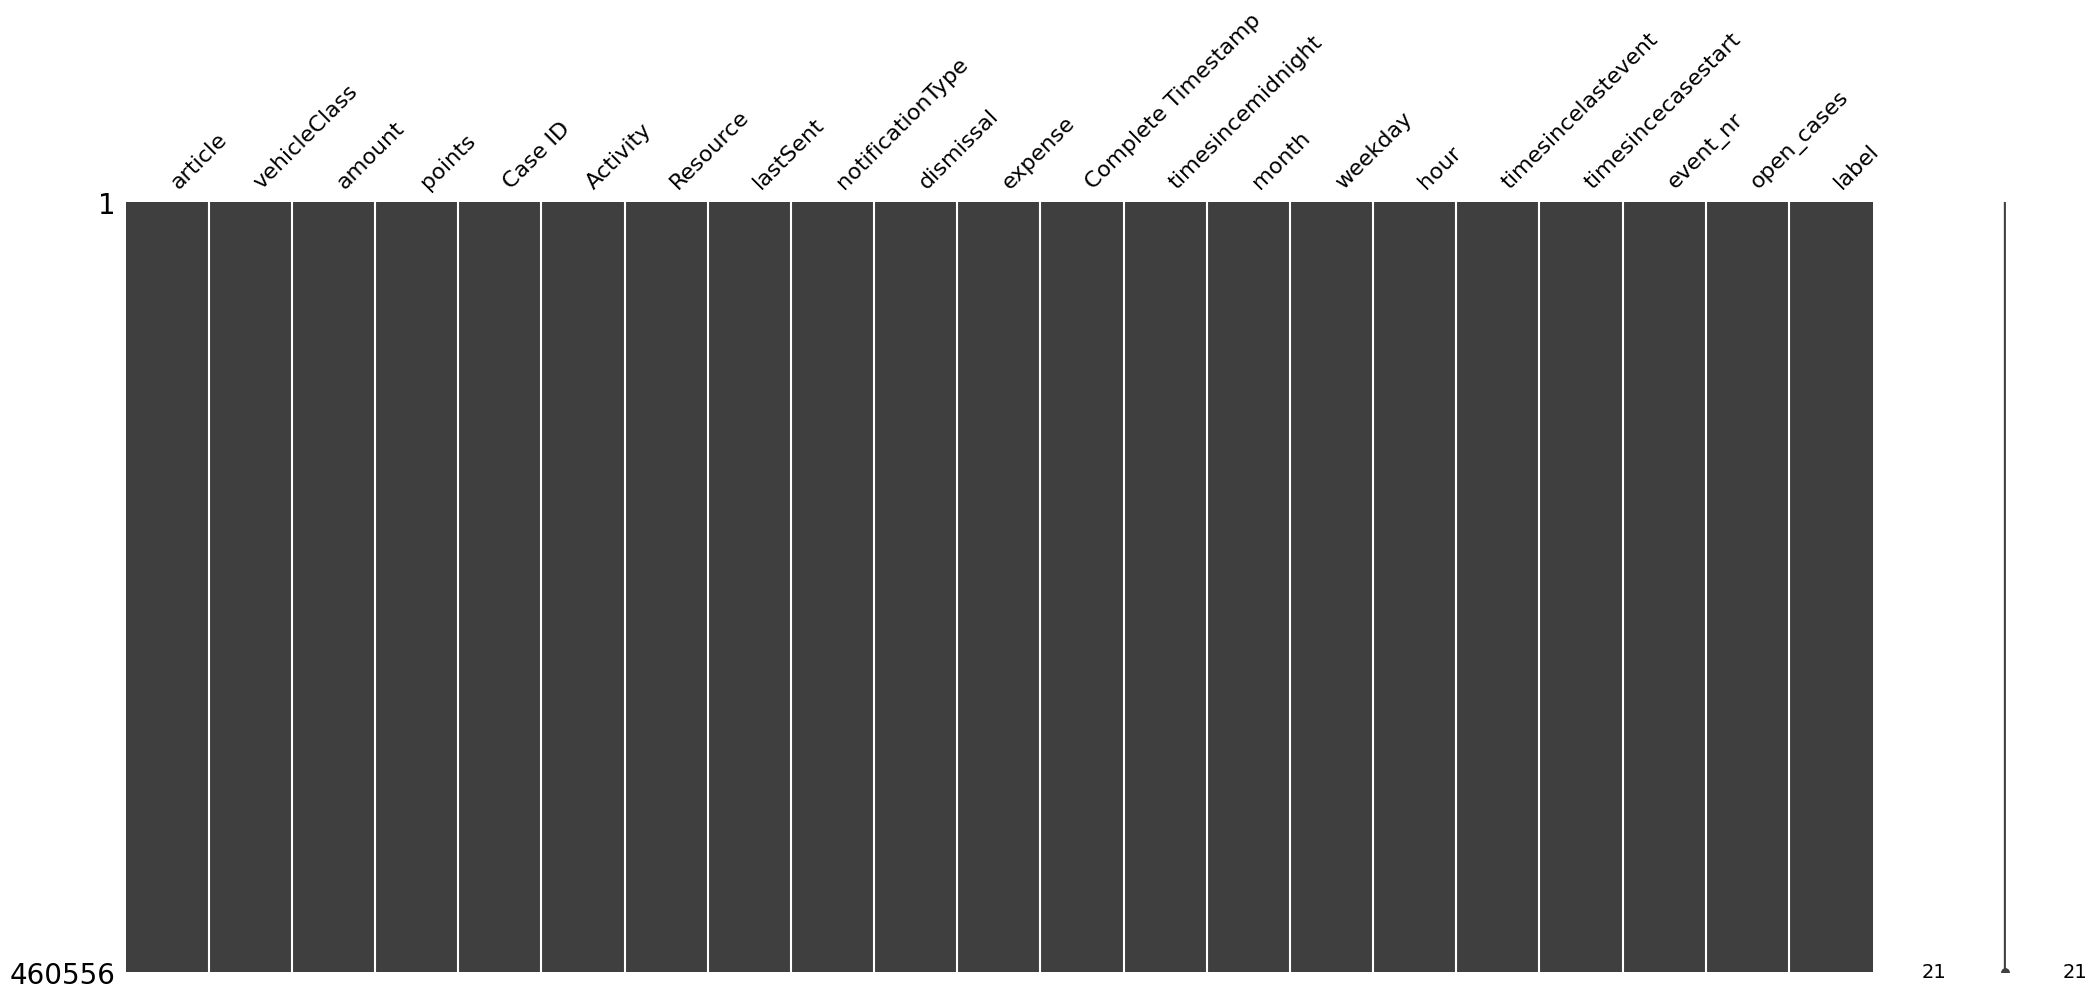

In [10]:
msno.matrix(log)

In [11]:
log.rename(columns={"Case ID": "id", "Complete Timestamp": "timestamp"}, inplace=True)
log.head()

,article,vehicleClass,amount,points,id,Activity,Resource,lastSent,notificationType,dismissal,...,timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,...,2006-08-02 01:00:00,60,8,2,1,0.0,0.0,1,11246,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,...,2006-12-12 01:00:00,60,12,1,1,190080.0,190080.0,2,12380,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,...,2007-01-15 01:00:00,60,1,0,1,48960.0,239040.0,3,12202,deviant
3,157.0,A,71.5,0.0,A100,Add penalty,561.0,P,P,NIL,...,2007-03-16 01:00:00,60,3,4,1,86400.0,325440.0,4,7749,deviant
4,157.0,A,36.0,0.0,A10000,Create Fine,561.0,missing,missing,NIL,...,2007-03-09 01:00:00,60,3,4,1,0.0,0.0,1,7756,regular


In [12]:
log["id"].describe()

count     460556
unique    129615
top       C20817
freq          20
Name: id, dtype: object

In [13]:
log["timestamp"] = pd.to_datetime(log["timestamp"])

In [14]:
selected_year = 2006

log_2006 = log[log["timestamp"].dt.year == selected_year]

log_other = log[log["timestamp"].dt.year != selected_year]

In [15]:
ids = log_2006["id"].unique()
other_ids = log_other["id"].unique()

for selected_id in ids:
    if selected_id in other_ids:
        log_2006 = log_2006.drop(log_2006[log_2006["id"] == selected_id].index)

log = log_2006.reset_index(drop=True)
log

,article,vehicleClass,amount,points,id,Activity,Resource,lastSent,notificationType,dismissal,...,timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,7.0,A,21.0,0.0,A1006,Create Fine,550.0,missing,missing,NIL,...,2006-08-08 01:00:00,60,8,1,1,0.0,0.0,1,11574,regular
1,7.0,A,21.0,0.0,A1006,Payment,550.0,missing,missing,NIL,...,2006-09-12 01:00:00,60,9,1,1,50400.0,50400.0,2,12549,regular
2,157.0,A,35.0,0.0,A1065,Create Fine,557.0,missing,missing,NIL,...,2006-08-07 01:00:00,60,8,0,1,0.0,0.0,1,11552,regular
3,157.0,A,35.0,0.0,A1065,Payment,557.0,missing,missing,NIL,...,2006-08-10 01:00:00,60,8,3,1,4320.0,4320.0,2,11600,regular
4,7.0,A,35.0,0.0,A1067,Create Fine,557.0,missing,missing,NIL,...,2006-08-07 01:00:00,60,8,0,1,0.0,0.0,1,11553,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19102,142.0,A,286.5,2.0,V15849,Add penalty,844.0,P,P,NIL,...,2006-12-25 01:00:00,60,12,0,1,86400.0,290880.0,4,12248,deviant
19103,142.0,A,143.0,2.0,V15852,Create Fine,844.0,missing,missing,NIL,...,2006-06-06 01:00:00,60,6,1,1,0.0,0.0,1,9235,deviant
19104,142.0,A,143.0,2.0,V15852,Send Fine,844.0,missing,missing,NIL,...,2006-10-11 01:00:00,60,10,2,1,182880.0,182880.0,2,12527,deviant
19105,142.0,A,143.0,2.0,V15852,Insert Fine Notification,844.0,P,P,NIL,...,2006-10-23 01:00:00,60,10,0,1,17280.0,200160.0,3,12471,deviant


### preprocessing and encode

In [16]:
log = elp.EventLog(log, "id", "timestamp")

In [17]:
log.df.columns

Index(['article', 'vehicleClass', 'amount', 'points', 'id', 'Activity',
       'Resource', 'lastSent', 'notificationType', 'dismissal', 'expense',
       'timestamp', 'timesincemidnight', 'month', 'weekday', 'hour',
       'timesincelastevent', 'timesincecasestart', 'event_nr', 'open_cases',
       'label'],
      dtype='object')

In [18]:
log.df.head()

,article,vehicleClass,amount,points,id,Activity,Resource,lastSent,notificationType,dismissal,...,timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,7.0,A,21.0,0.0,A1006,Create Fine,550.0,missing,missing,NIL,...,2006-08-08 01:00:00,60,8,1,1,0.0,0.0,1,11574,regular
1,7.0,A,21.0,0.0,A1006,Payment,550.0,missing,missing,NIL,...,2006-09-12 01:00:00,60,9,1,1,50400.0,50400.0,2,12549,regular
2,157.0,A,35.0,0.0,A1065,Create Fine,557.0,missing,missing,NIL,...,2006-08-07 01:00:00,60,8,0,1,0.0,0.0,1,11552,regular
3,157.0,A,35.0,0.0,A1065,Payment,557.0,missing,missing,NIL,...,2006-08-10 01:00:00,60,8,3,1,4320.0,4320.0,2,11600,regular
4,7.0,A,35.0,0.0,A1067,Create Fine,557.0,missing,missing,NIL,...,2006-08-07 01:00:00,60,8,0,1,0.0,0.0,1,11553,regular


In [19]:
colums_to_encode = list(log.df.select_dtypes(include="object").columns)
colums_to_encode.remove("id")
colums_to_encode.remove("article")
colums_to_encode.remove("Resource")

print(colums_to_encode)

causality.label_encode(log.df, colums_to_encode)

log.df.head()

['vehicleClass', 'Activity', 'lastSent', 'notificationType', 'dismissal', 'label']


,article,vehicleClass,amount,points,id,Activity,Resource,lastSent,notificationType,dismissal,...,timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,7.0,0,21.0,0.0,A1006,2,550.0,2,2,2,...,2006-08-08 01:00:00,60,8,1,1,0.0,0.0,1,11574,1
1,7.0,0,21.0,0.0,A1006,6,550.0,2,2,2,...,2006-09-12 01:00:00,60,9,1,1,50400.0,50400.0,2,12549,1
2,157.0,0,35.0,0.0,A1065,2,557.0,2,2,2,...,2006-08-07 01:00:00,60,8,0,1,0.0,0.0,1,11552,1
3,157.0,0,35.0,0.0,A1065,6,557.0,2,2,2,...,2006-08-10 01:00:00,60,8,3,1,4320.0,4320.0,2,11600,1
4,7.0,0,35.0,0.0,A1067,2,557.0,2,2,2,...,2006-08-07 01:00:00,60,8,0,1,0.0,0.0,1,11553,1


In [20]:
log.df["article"].replace("other", float("0"), inplace=True)
log.df["article"] = log.df["article"].astype(float)
log.df["Resource"].replace("other", float("0"), inplace=True)
log.df["Resource"] = log.df["Resource"].astype(float)

/tmp/ipykernel_104630/1735828470.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  log.df["article"].replace("other", float("0"), inplace=True)
/tmp/ipykernel_104630/1735828470.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [21]:
import elp.encoders as en

encoder = en.LogEncoder(
    transformers=[
        ("drop", "drop", ["id"]),
        (
            "keep",
            "keep",
            [
                "article",
                "vehicleClass",
                "amount",
                "points",
                "Activity",
                "Resource",
                "lastSent",
                "notificationType",
                "dismissal",
                "expense",
                "month",
                "weekday",
                "hour",
                "open_cases",
                "label",
            ],
        ),
        (
            "timestamp",
            en.TimestampFeatures(
                log.id_column,
                [
                    "event_order",
                    "time_from_start",
                    "time_from_midnight",
                    "total_time",
                    "elapsed_time_from_event",
                ],
                unit="1h",
            ),
            [log.timestamp_column],
        ),
    ]
)

encoder.check_unused(log)

['timesincemidnight', 'timesincelastevent', 'timesincecasestart', 'event_nr']

In [22]:
dataset = encoder.fit_transform(log)

Fitting drop
Fitting keep
Fitting timestamp
Transforming drop
Transforming keep
Transforming timestamp


In [23]:
dataset

,article,vehicleClass,amount,points,Activity,Resource,lastSent,notificationType,dismissal,expense,month,weekday,hour,open_cases,label,event_order_timestamp,time_from_start_timestamp,time_from_midnight_timestamp,total_time_timestamp,elapsed_time_from_event_timestamp
0,7.0,0,21.0,0.0,2,550.0,2,2,2,0.00,8,1,1,11574,1,0,0.0,1.0,840.0,0.0
1,7.0,0,21.0,0.0,6,550.0,2,2,2,0.00,9,1,1,12549,1,1,840.0,1.0,840.0,840.0
2,157.0,0,35.0,0.0,2,557.0,2,2,2,0.00,8,0,1,11552,1,0,0.0,1.0,72.0,0.0
3,157.0,0,35.0,0.0,6,557.0,2,2,2,0.00,8,3,1,11600,1,1,72.0,1.0,72.0,72.0
4,7.0,0,35.0,0.0,2,557.0,2,2,2,0.00,8,0,1,11553,1,0,0.0,1.0,216.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19102,142.0,0,286.5,2.0,0,844.0,1,1,2,14.25,12,0,1,12248,0,3,4848.0,1.0,4848.0,1440.0
19103,142.0,0,143.0,2.0,2,844.0,2,2,2,0.00,6,1,1,9235,0,0,0.0,1.0,4776.0,0.0
19104,142.0,0,143.0,2.0,9,844.0,2,2,2,11.00,10,2,1,12527,0,1,3048.0,1.0,4776.0,3048.0
19105,142.0,0,143.0,2.0,4,844.0,1,1,2,11.00,10,0,1,12471,0,2,3336.0,1.0,4776.0,288.0


### run base experiment

Split 0: 3187 train rows, 3184 test rows
{'mse': 47537.8963959799,
 'rmse': 218.03187013824356,
 'split': 0,
 'time': 0.09606719017028809}


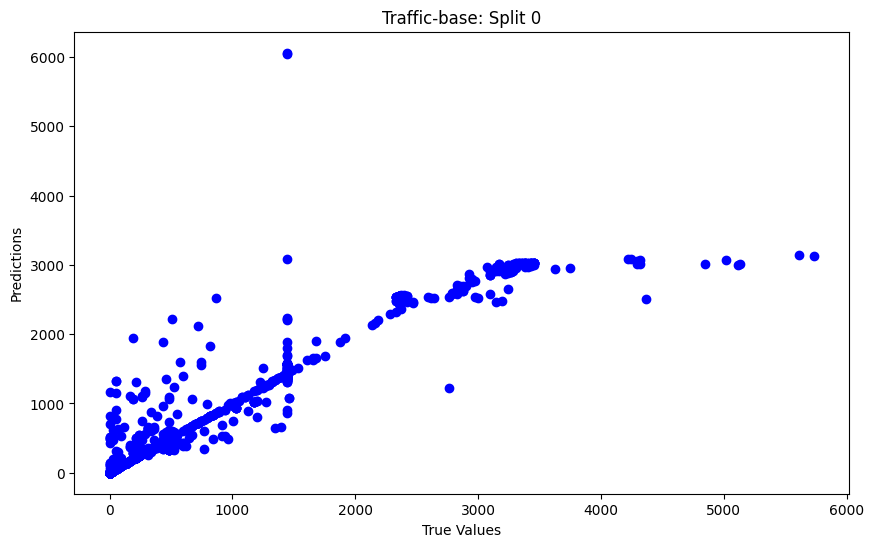

Split 1: 6371 train rows, 3184 test rows
{'mse': 28253.920576884426,
 'rmse': 168.08902574791855,
 'split': 1,
 'time': 0.09451723098754883}


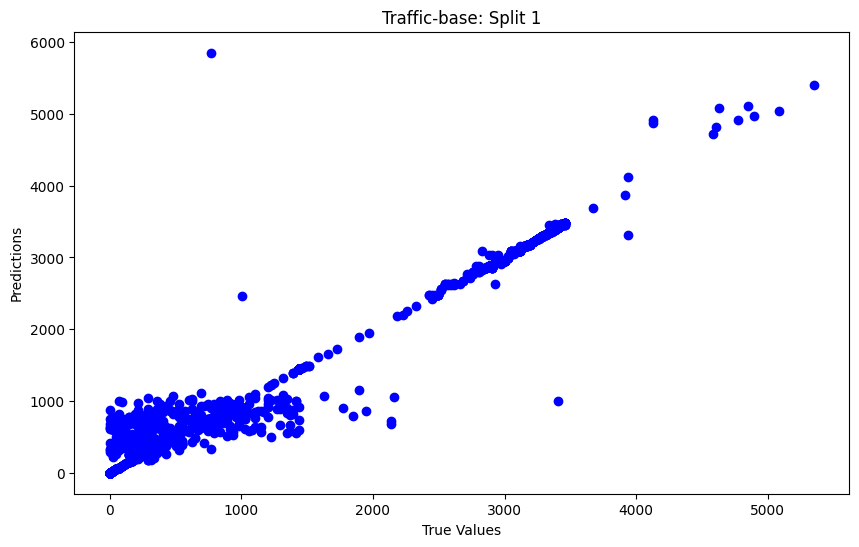

Split 2: 9555 train rows, 3184 test rows
{'mse': 7547.496168844221,
 'rmse': 86.87632686091315,
 'split': 2,
 'time': 0.10376620292663574}


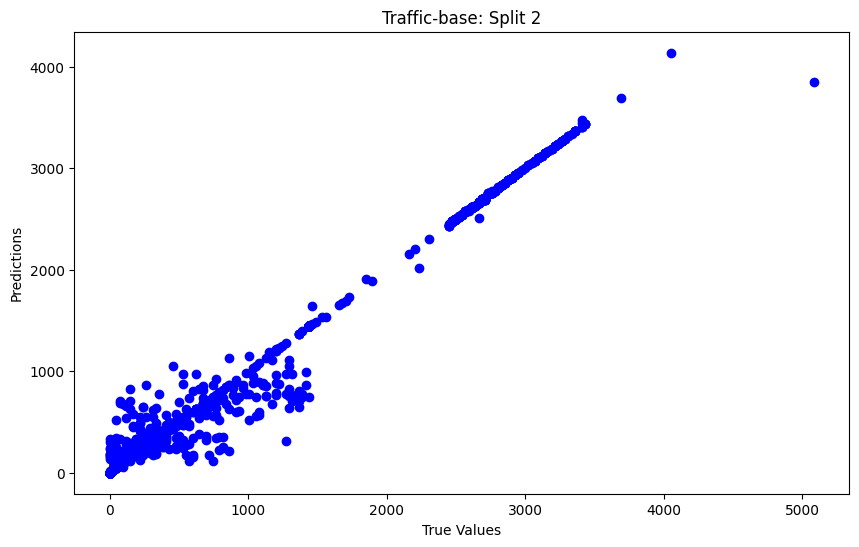

Split 3: 12739 train rows, 3184 test rows
{'mse': 6995.5231839195985,
 'rmse': 83.63924428113634,
 'split': 3,
 'time': 0.12784147262573242}


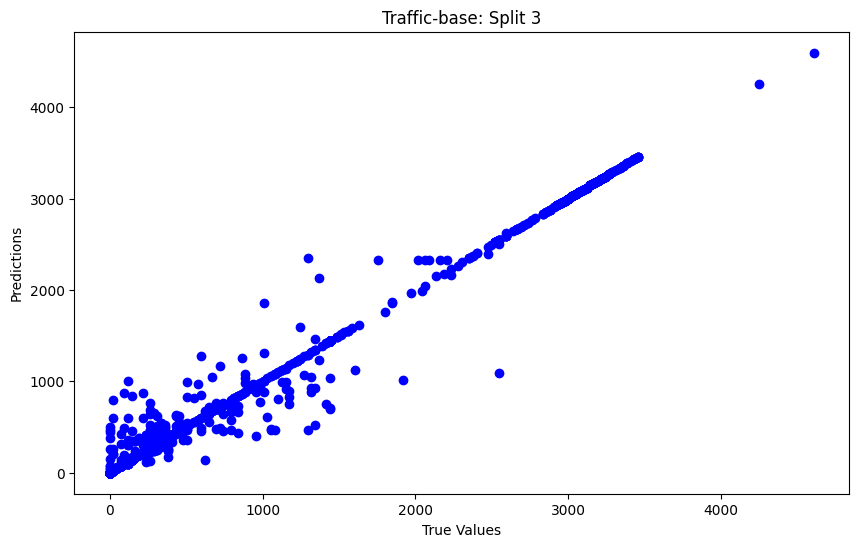

Split 4: 15923 train rows, 3184 test rows
{'mse': 4700.276810050251,
 'rmse': 68.55856481906729,
 'split': 4,
 'time': 0.15240144729614258}


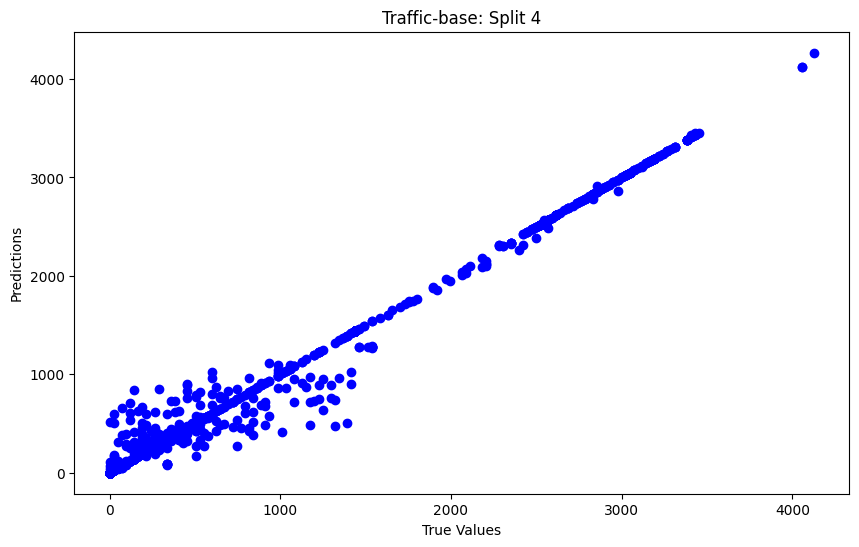

{'mse': 19007.02262713568, 'rmse': 125.03900636945578}


In [24]:
results_base = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="Traffic",
    experiment="base",
)

### causal inference and causal informed prediction

/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Depth=0, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 842.00it/s]


X2 --> X1
X6 --> X1
X3 --> X6
X10 --> X8
X11 --> X14
X20 --> X15


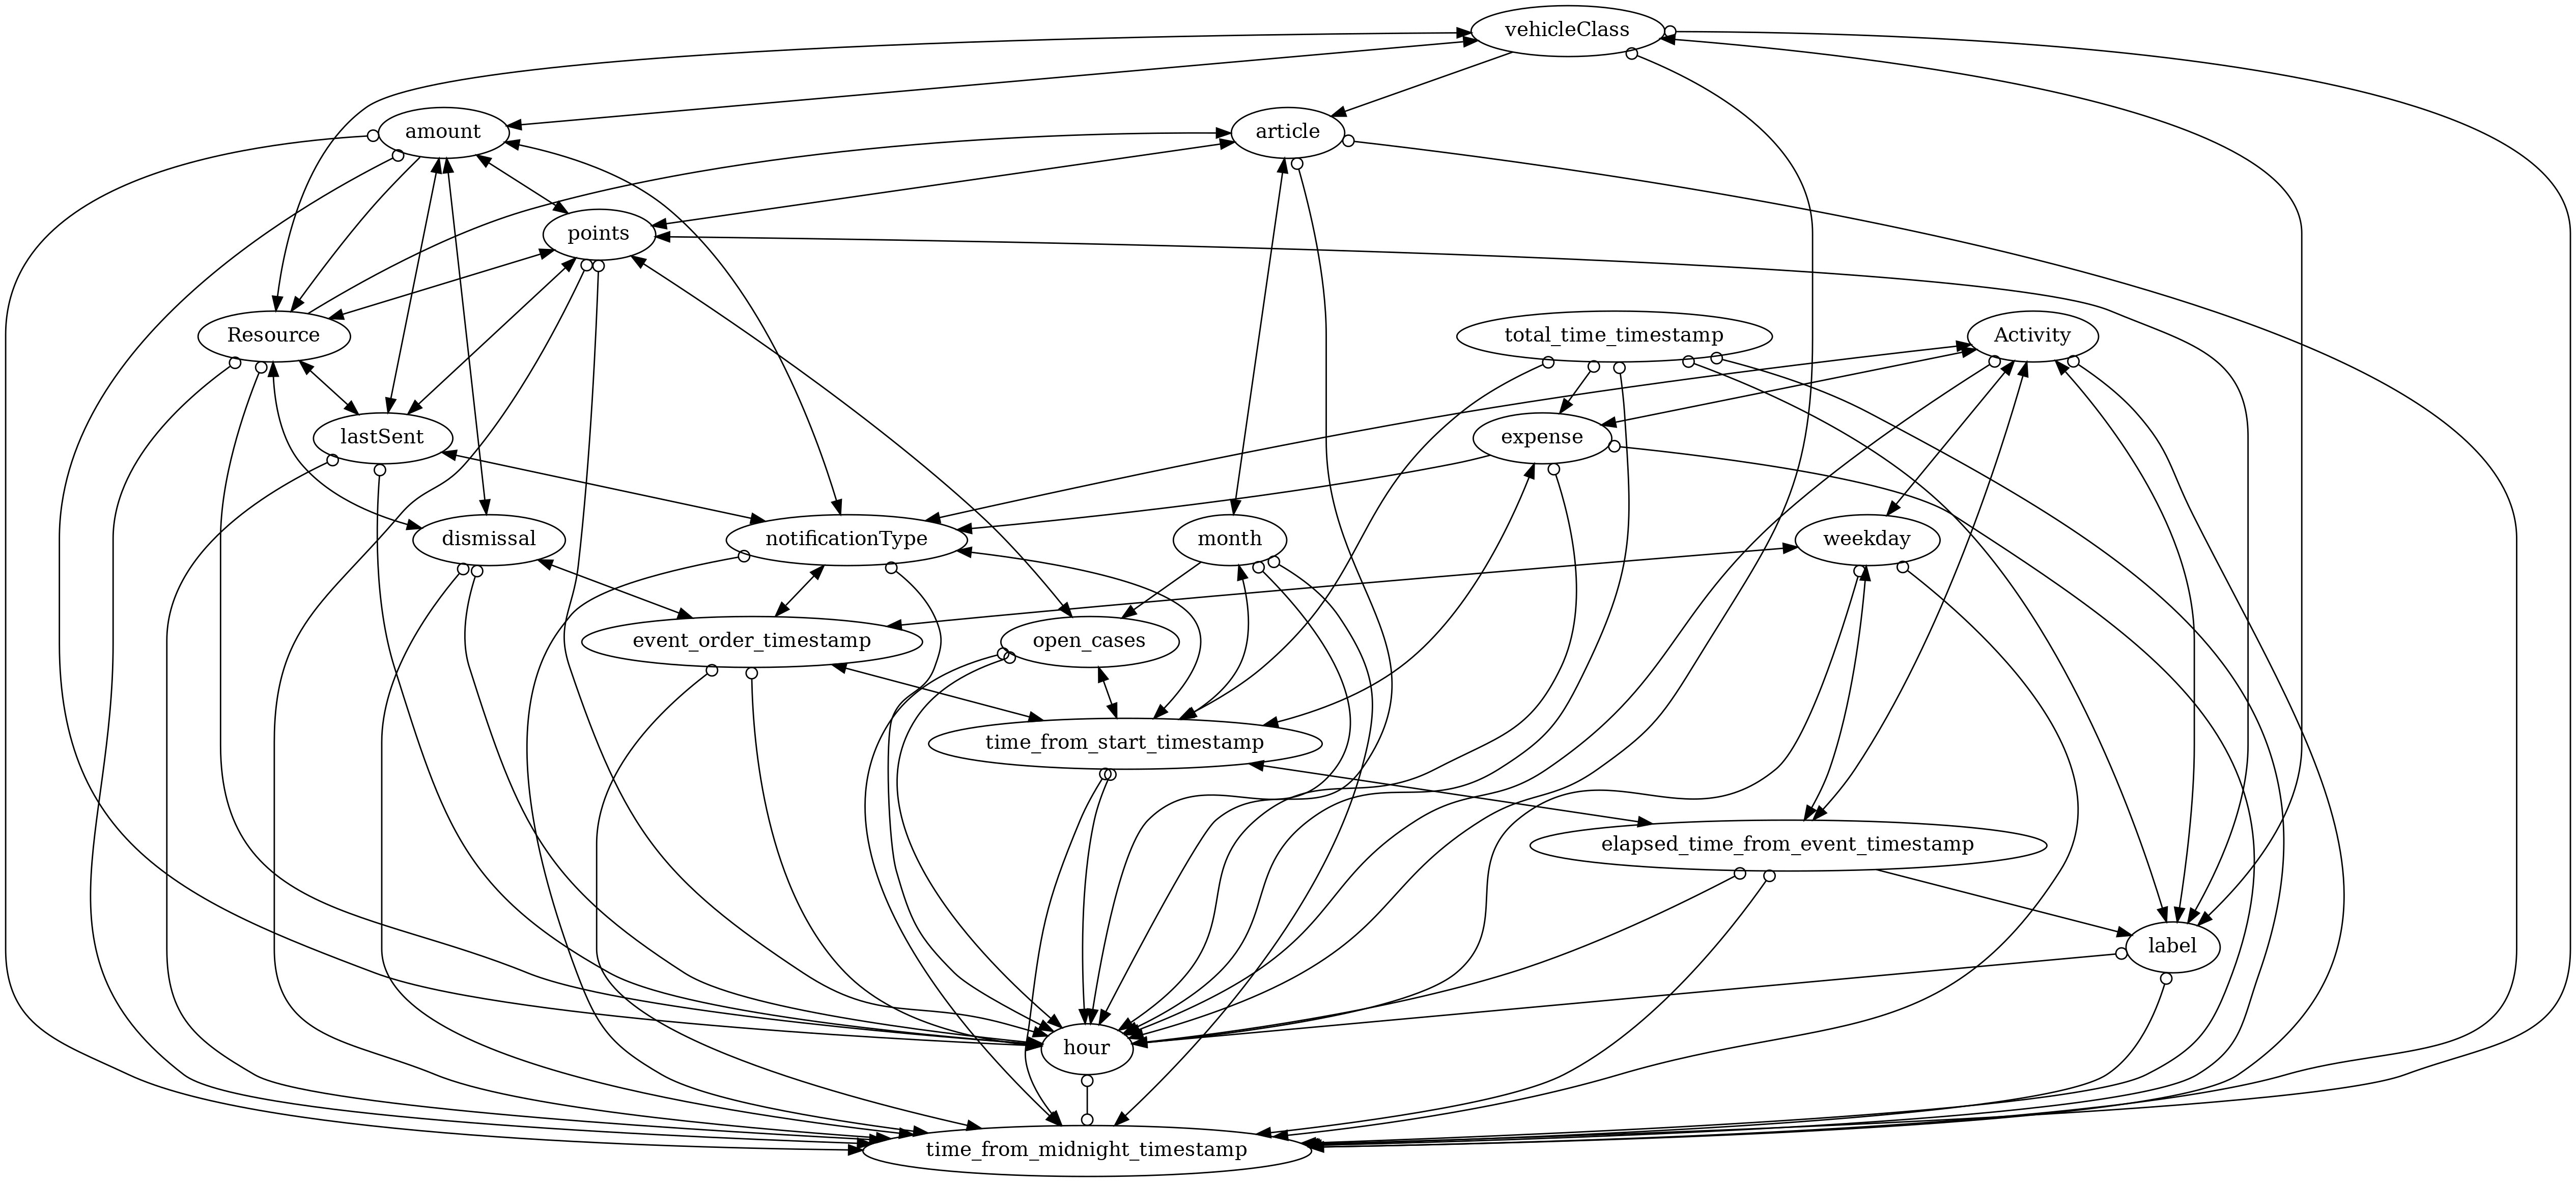

In [25]:
graph = causality.causal_inference_fci(dataset, "Traffic")

In [31]:
parents = ["Activity", "weekday", "time_from_start_timestamp"]

parents_of_parents = {
    "Activity": ["expense", "label"],
    "weekday": [
        "event_order_timestamp",
    ],
    "time_from_start_timestamp": ["notificationType", "open_cases", "month"],
}
parents_2_order = list(parents_of_parents.keys()) + [
    item for sublist in parents_of_parents.values() for item in sublist
]

### run only 1 order parents experiment

/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/experiments/causality.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


Split 0: 3187 train rows, 3184 test rows
{'mse': 83971.2476335301,
 'rmse': 289.7779281338213,
 'split': 0,
 'time': 0.08514022827148438}


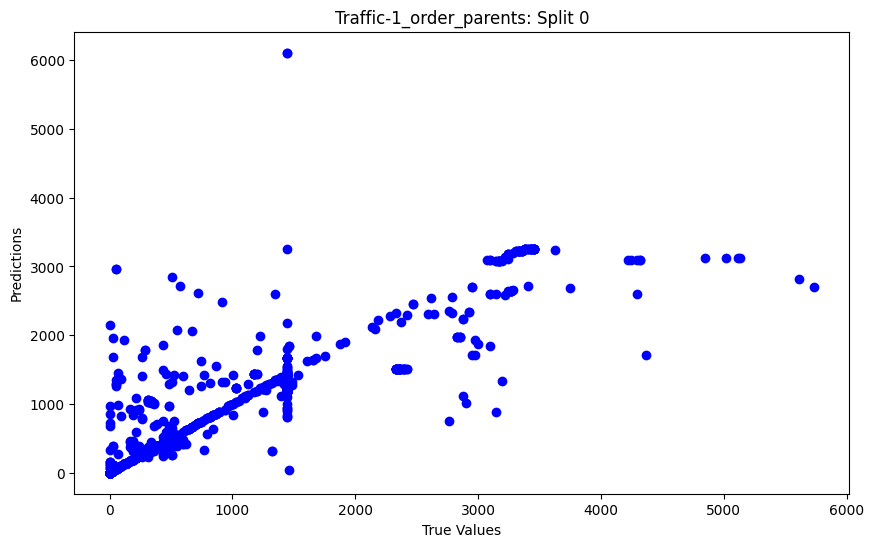

Split 1: 6371 train rows, 3184 test rows
{'mse': 71973.50196445483,
 'rmse': 268.27877658222394,
 'split': 1,
 'time': 0.07980084419250488}


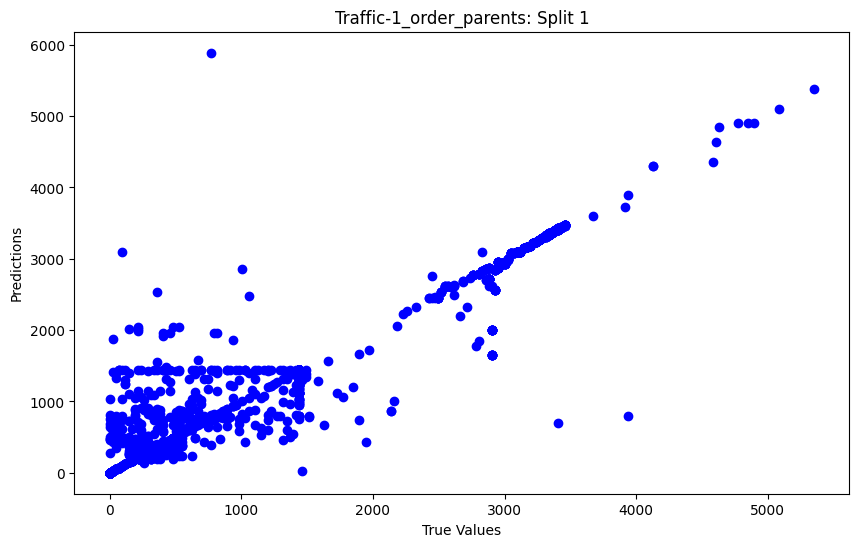

Split 2: 9555 train rows, 3184 test rows
{'mse': 76507.39028260372,
 'rmse': 276.599693207718,
 'split': 2,
 'time': 0.08698797225952148}


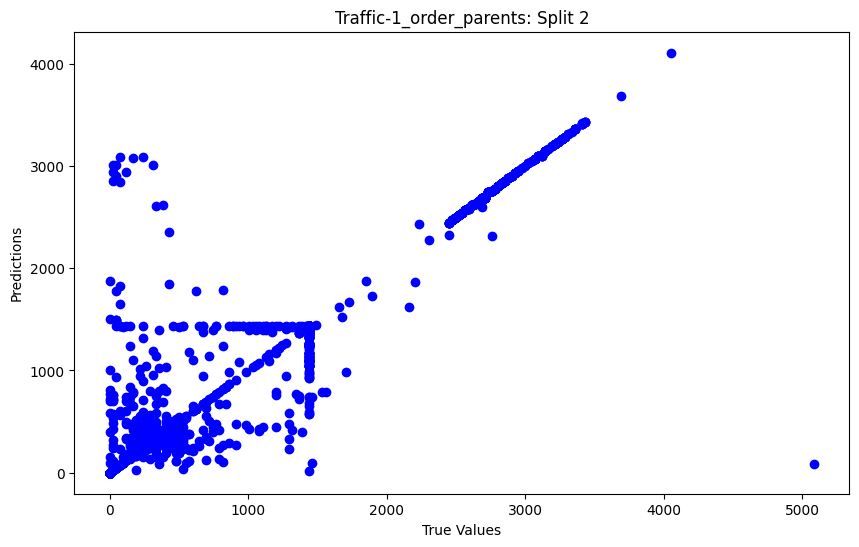

Split 3: 12739 train rows, 3184 test rows
{'mse': 21200.23237815727,
 'rmse': 145.60299577329195,
 'split': 3,
 'time': 0.09096026420593262}


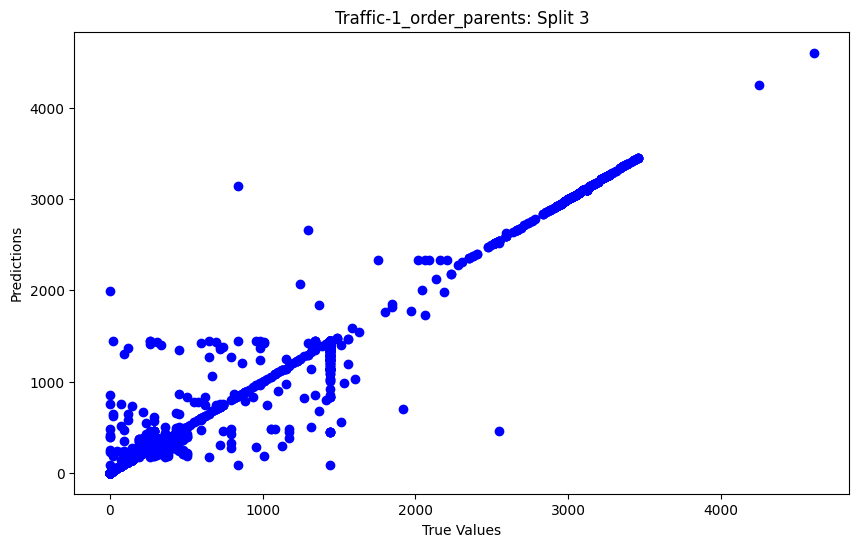

Split 4: 15923 train rows, 3184 test rows
{'mse': 25101.12274045232,
 'rmse': 158.43333847537366,
 'split': 4,
 'time': 0.09380125999450684}


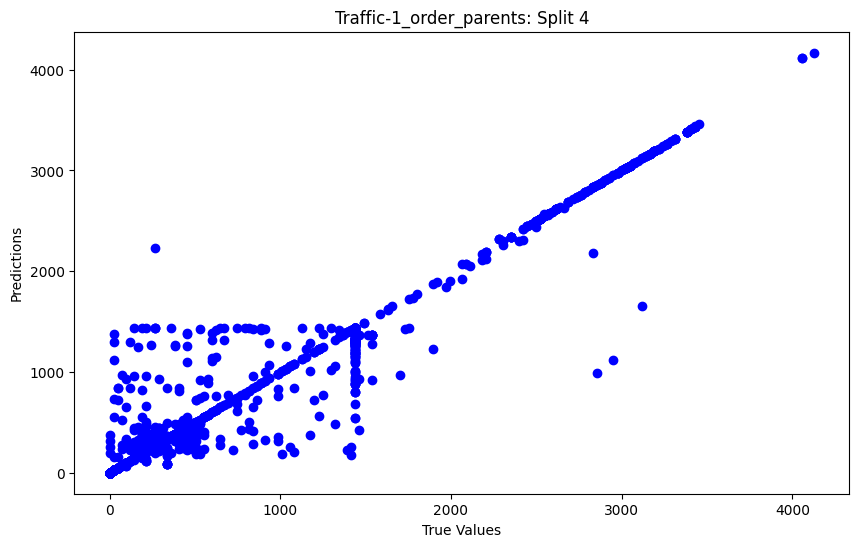

{'mse': 55750.698999839646, 'rmse': 227.73854643448576}


In [27]:
columns = parents + ["elapsed_time_from_event_timestamp"]

results_1_order_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="Traffic",
    experiment="1_order_parents",
    columns=columns,
)

### run without parents experiments

Split 0: 3187 train rows, 3184 test rows
{'mse': 96732.9652160804,
 'rmse': 311.0192360869025,
 'split': 0,
 'time': 0.07278847694396973}


/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/experiments/causality.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


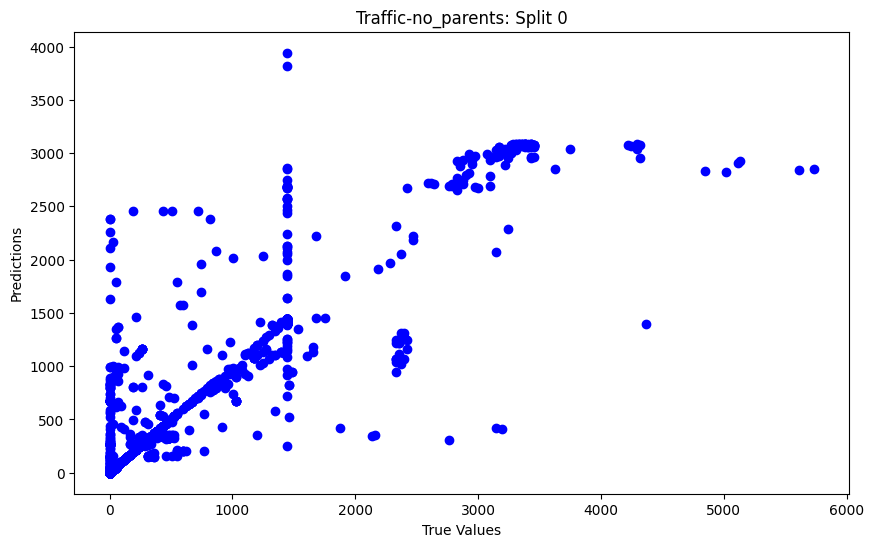

Split 1: 6371 train rows, 3184 test rows
{'mse': 41865.10151155779,
 'rmse': 204.60963201070908,
 'split': 1,
 'time': 0.0833895206451416}


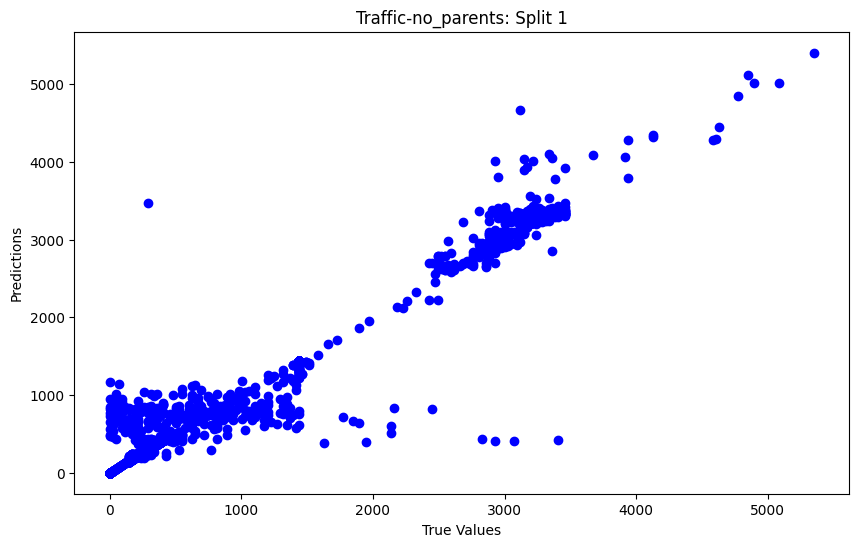

Split 2: 9555 train rows, 3184 test rows
{'mse': 14357.11168134758,
 'rmse': 119.82116541474457,
 'split': 2,
 'time': 0.09165501594543457}


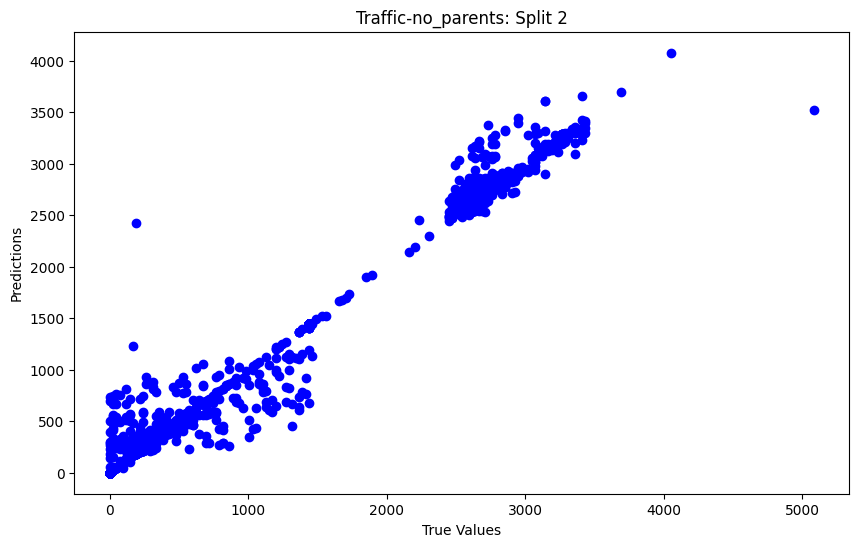

Split 3: 12739 train rows, 3184 test rows
{'mse': 27923.92205730079,
 'rmse': 167.10452434719053,
 'split': 3,
 'time': 0.1051793098449707}


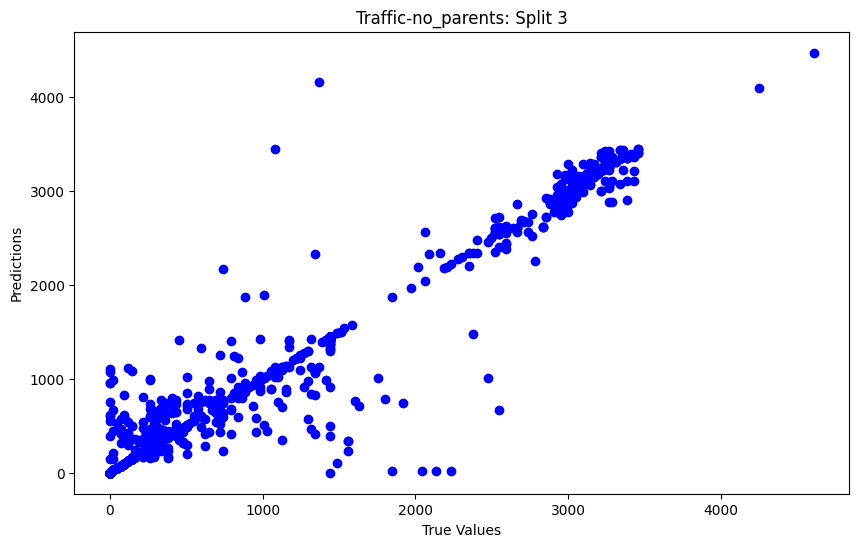

Split 4: 15923 train rows, 3184 test rows
{'mse': 16761.143379745667,
 'rmse': 129.46483452948013,
 'split': 4,
 'time': 0.11425447463989258}


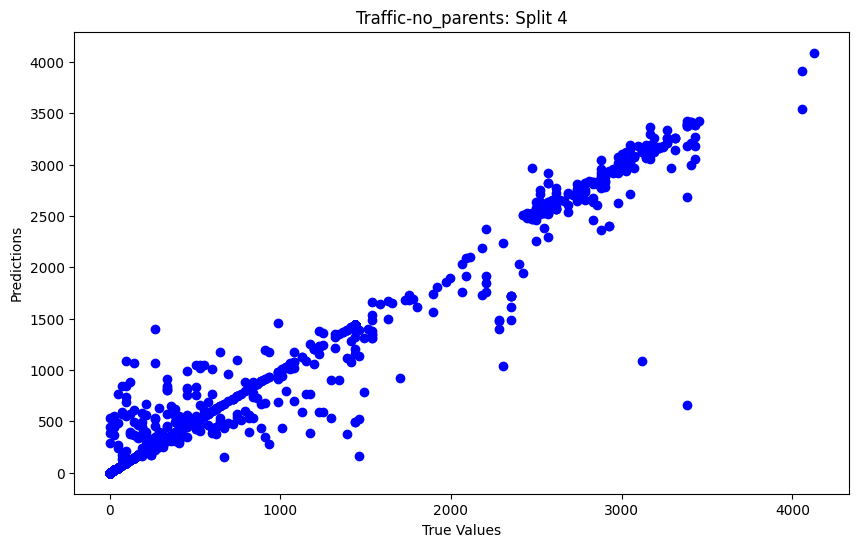

{'mse': 39528.048769206434, 'rmse': 186.40387847780534}


In [28]:
columns = filter(lambda i: i not in parents, dataset.columns.tolist())

results_no_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="Traffic",
    experiment="no_parents",
    columns=columns,
)

### run second order parents experiments

Split 0: 3187 train rows, 3184 test rows
{'mse': 46448.2183839196,
 'rmse': 215.51848733674706,
 'split': 0,
 'time': 0.07500386238098145}


/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/experiments/causality.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


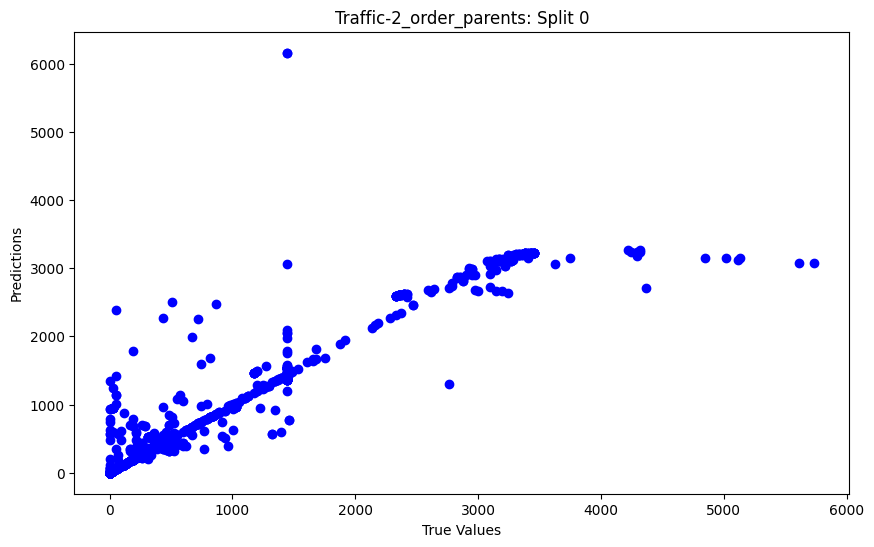

Split 1: 6371 train rows, 3184 test rows
{'mse': 32970.47588140704,
 'rmse': 181.57774060001694,
 'split': 1,
 'time': 0.0813288688659668}


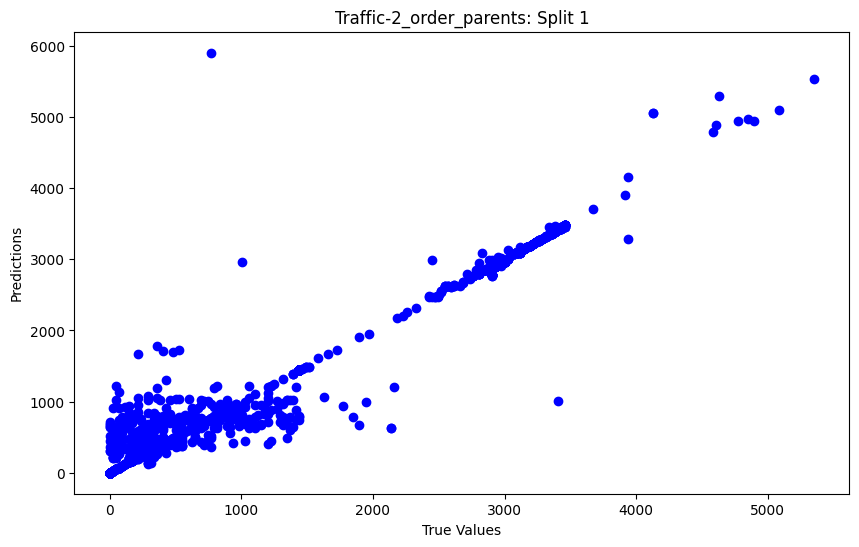

Split 2: 9555 train rows, 3184 test rows
{'mse': 7815.393744065327,
 'rmse': 88.40471562120048,
 'split': 2,
 'time': 0.09484171867370605}


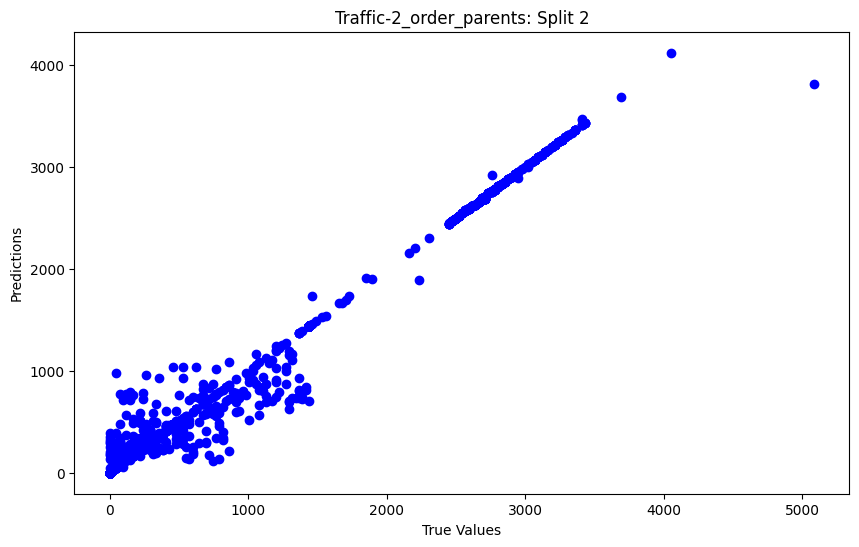

Split 3: 12739 train rows, 3184 test rows
{'mse': 6354.945565682598,
 'rmse': 79.71791245186114,
 'split': 3,
 'time': 0.1002347469329834}


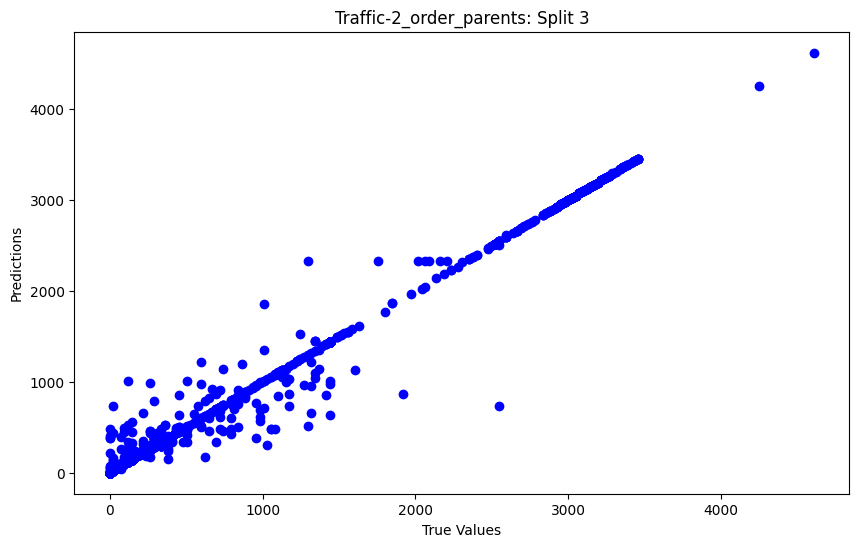

Split 4: 15923 train rows, 3184 test rows
{'mse': 5094.947482318327,
 'rmse': 71.37890082032874,
 'split': 4,
 'time': 0.09968852996826172}


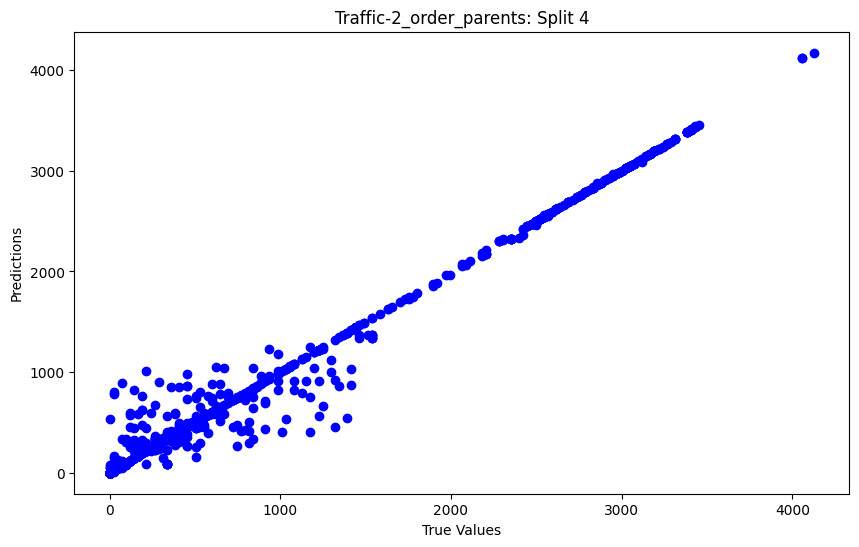

{'mse': 19736.796211478577, 'rmse': 127.31955136603088}


In [29]:
columns = parents_2_order + ["elapsed_time_from_event_timestamp"]

results_2_order_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="Traffic",
    experiment="2_order_parents",
    columns=columns,
)